In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import copy

In [2]:
from datetime import timedelta
import datetime

In [3]:
import keras
import sklearn

2024-05-02 05:14:38.640007: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
import tensorflow as tf
import random
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# read data

In [5]:
path_files = '/glade/derecho/scratch/jhayron/PrecipitationForecasting/'

In [6]:
deseasonalized_pacific = pd.read_csv(f'{path_files}deseasonalized_pacific.csv',
            index_col=0,parse_dates=True)
deseasonalized_mountain = pd.read_csv(f'{path_files}deseasonalized_mountain.csv',
            index_col=0,parse_dates=True)
deseasonalized_central = pd.read_csv(f'{path_files}deseasonalized_central.csv',
            index_col=0,parse_dates=True)
deseasonalized_eastern = pd.read_csv(f'{path_files}deseasonalized_eastern.csv',
            index_col=0,parse_dates=True)

# only pacific for now

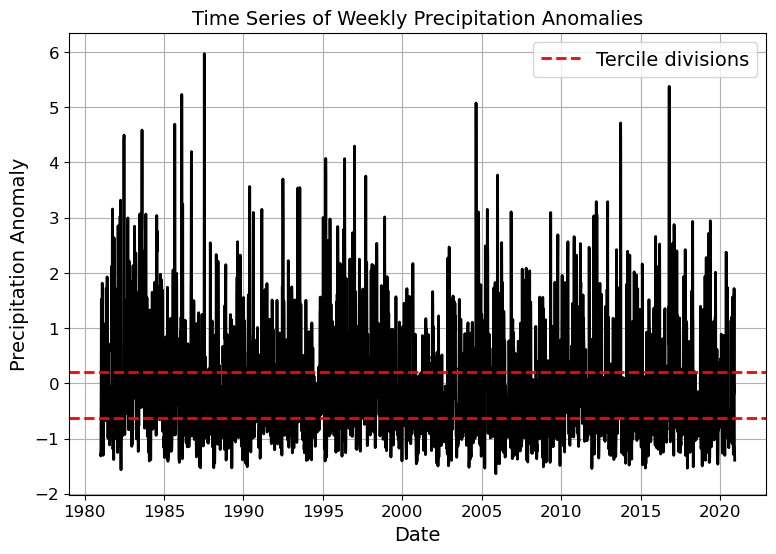

In [291]:
terciles = np.percentile(deseasonalized_pacific, [33.33, 66.66])

plt.figure(figsize=(9, 6))

# Plot the time series with a black line
plt.plot(deseasonalized_pacific, color='black', linewidth=2, linestyle='-')

# Plot horizontal lines for each tercile
plt.axhline(y=terciles[0], color='red', linestyle='--', linewidth=2, label = 'Tercile divisions')
plt.axhline(y=terciles[1], color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Date',fontsize=14)
plt.ylabel('Precipitation Anomaly',fontsize=14)
plt.title('Time Series of Weekly Precipitation Anomalies',fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Show the plot
plt.show()

In [8]:
initial_df = copy.deepcopy(deseasonalized_pacific)

In [9]:
initial_df.columns = ['week0']

In [10]:
dp2 = initial_df[initial_df.index.dayofweek==3]

In [11]:
lag = 1
df_temp = pd.concat([dp2['week0'],\
                     dp2.shift(-lag)['week0']],axis=1).dropna()
np.corrcoef(df_temp.iloc[:,0],df_temp.iloc[:,1])

array([[1.        , 0.19885933],
       [0.19885933, 1.        ]])

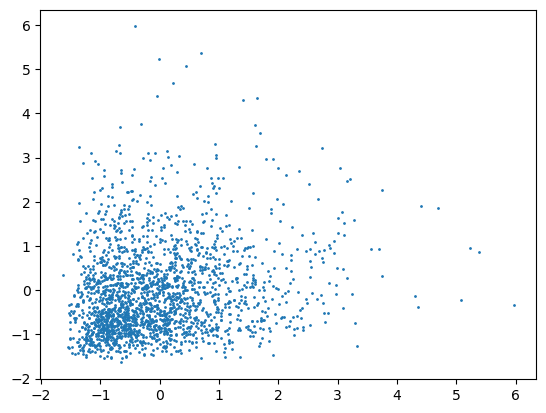

In [12]:
plt.scatter(df_temp.iloc[:,0],df_temp.iloc[:,1],s=1)

In [13]:
np.arange(2,10)

array([2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
try: del(df_shifts)
except: pass
# for wk in range(2,10):
for wk in [2, 3, 4, 5, 6, 7, 8, 9, 0, -1, -2, -3, -4]:
    series_temp = copy.deepcopy(initial_df["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(initial_df["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

In [15]:
df_shifts = df_shifts.dropna()

In [16]:
df_shifts

,week0,week1,week2,week3,week4,week5,week6,week7,week8,week-1,week-2,week-3,week-4,week-5
1981-02-09,1.023730,0.068429,-0.206263,-0.424186,-0.706761,0.262680,0.886463,0.123267,-0.086678,-1.057468,0.839116,0.206458,-1.151480,-1.286863
1981-02-12,1.814303,-0.583376,-0.054296,-1.302033,-0.217162,1.079898,0.559497,-0.281472,-0.603352,-0.646584,-1.044990,1.522827,-0.601598,-1.314276
1981-02-16,0.068429,-0.206263,-0.424186,-0.706761,0.262680,0.886463,0.123267,-0.086678,-0.187693,1.023730,-1.057468,0.839116,0.206458,-1.151480
1981-02-19,-0.583376,-0.054296,-1.302033,-0.217162,1.079898,0.559497,-0.281472,-0.603352,0.419285,1.814303,-0.646584,-1.044990,1.522827,-0.601598
1981-02-23,-0.206263,-0.424186,-0.706761,0.262680,0.886463,0.123267,-0.086678,-0.187693,0.099182,0.068429,1.023730,-1.057468,0.839116,0.206458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-17,0.579918,0.155025,-1.085650,1.563145,-0.692018,-0.953205,-0.910195,-0.202179,1.716688,-0.960285,-1.041983,-0.968127,-0.519626,-0.723437
2020-09-21,1.205332,-1.087561,0.865789,0.031157,-0.756830,-1.284891,-0.017801,0.675779,-0.105073,-0.383386,-1.032966,-1.012683,-0.838500,-0.484293
2020-09-24,0.155025,-1.085650,1.563145,-0.692018,-0.953205,-0.910195,-0.202179,1.716688,-1.089201,0.579918,-0.960285,-1.041983,-0.968127,-0.519626
2020-09-28,-1.087561,0.865789,0.031157,-0.756830,-1.284891,-0.017801,0.675779,-0.105073,-1.175503,1.205332,-0.383386,-1.032966,-1.012683,-0.838500


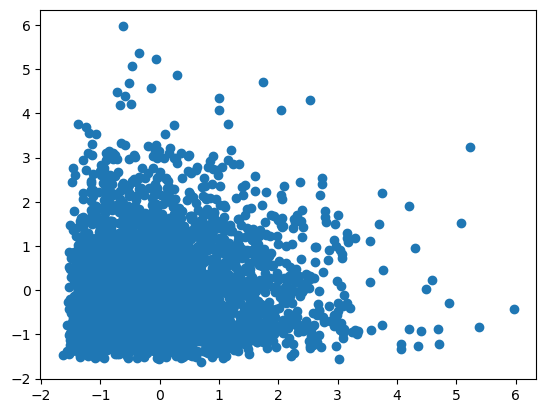

In [17]:
plt.scatter(df_shifts['week0'],df_shifts['week3'])

In [18]:
np.corrcoef(df_shifts['week0'],df_shifts['week4'])

array([[1.        , 0.03827432],
       [0.03827432, 1.        ]])

In [19]:
output = pd.DataFrame(df_shifts[['week3','week4']].dropna().mean(axis=1))
# output = pd.DataFrame(df_shifts[['week1']].dropna().mean(axis=1))
# output = pd.DataFrame(df_shifts[['week3']].dropna().mean(axis=1))

In [20]:
output#.dropna()

,0
1981-02-09,-0.565474
1981-02-12,-0.759597
1981-02-16,-0.222040
1981-02-19,0.431368
1981-02-23,0.574571
...,...
2020-09-17,0.435564
2020-09-21,-0.362836
2020-09-24,-0.822611
2020-09-28,-1.020860


In [21]:
# percs = np.percentile(output,[0,20,40,60,80,100])
percs = np.percentile(output,[0,100/3,2*100/3,100])
percs[0] = percs[0]-0.1
percs[-1] = percs[-1]+0.1
sample_cut, sample_bins = pd.cut(output[0],percs, 
                                 retbins=True,labels= np.arange(0,3))

In [22]:

# create the object
onehotencode = OneHotEncoder()
# reshape the input array to be (samples, features)
sample_onehot = onehotencode.fit_transform(X=sample_cut.values.reshape(-1,1))

In [23]:
array_outputs = sample_onehot.toarray()

# read inputs

In [24]:
path_pcs = '/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/figures_detrended_20240317/'

In [25]:
list_folders = np.sort(glob.glob(f'{path_pcs}*/'))[:-1]
list_vars = [list_folders[i].split('/')[-2] for i in range(len(list_folders))]

In [26]:
dic_components = {
    'Z500_ERA5': [0,10],
    'OLR_ERA5': [1,8],
    'U10_ERA5': [3,6,10],
    'U200_ERA5': [0,15],
    'IT_SODA': [5,13,16],
    'MLD_SODA': [7,19],
    'OHC100_SODA': [0,5,6,3],
    'OHC200_SODA': [3,16,11],
    'OHC300_SODA': [0,2,16],
    'OHC50_SODA': [0,3,5,2],
    'OHC700_SODA': [1,6,10,14,0],
    'SSH_SODA': [0,2,7],
    'SST_SODA': [2,5,9,10],
    'SD_ERA5': [0],
    'STL_1m_ERA5': [13,17],
    'STL_28cm_ERA5': [1,10],
    'STL_7cm_ERA5': [1,5,7,10,14],
    'STL_full_ERA5': [7,9,14,15],
    'SWVL_1m_ERA5': [0,10,14,2,19],
    'SWVL_28cm_ERA5': [2,13,19,6,12,16],
    'SWVL_7cm_ERA5': [1,9,12,4],
    'SWVL_full_ERA5': [2,4,9,10,13,14,15],
}

In [27]:
for ivar,var in enumerate(list_vars):
    print(ivar,var)

0 IC_SODA
1 IT_SODA
2 MLD_SODA
3 OHC100_SODA
4 OHC200_SODA
5 OHC300_SODA
6 OHC50_SODA
7 OHC700_SODA
8 OLR_ERA5
9 SD_ERA5
10 SSH_SODA
11 SST_OISSTv2
12 SST_SODA
13 STL_1m_ERA5
14 STL_28cm_ERA5
15 STL_7cm_ERA5
16 STL_full_ERA5
17 SWVL_1m_ERA5
18 SWVL_28cm_ERA5
19 SWVL_7cm_ERA5
20 SWVL_full_ERA5
21 U10_ERA5
22 U200_ERA5
23 Z500_ERA5


In [28]:
# for ivar in range(len(list_vars)):
list_dfs_inputs = []
for ivar in [6,7,8,10,12,14,16,18,20,21,22,23]:
# for ivar in [6,7,8,21,22,23]:
# for ivar in [6,7,8,21,23]:
# for ivar in [7]:
    print(list_vars[ivar])
    pcs_temp = pd.read_csv(f'{list_folders[ivar]}PC_{list_vars[ivar]}.csv',
                              index_col=0,
                              parse_dates=True)
    # list_pcs = dic_components[list_vars[ivar]]
    # list_pcs = np.arange(1).tolist()
    list_pcs = np.arange(10).tolist()
    # list_pcs = np.arange(20).tolist()
    pcs_temp = pcs_temp[np.array(list_pcs).astype(str).tolist()]
    
    names_columns_temp = []
    for ipc in range(len(list_pcs)):
        names_columns_temp.append(f'{list_vars[ivar]}_{list_pcs[ipc]}')
    pcs_temp.columns = names_columns_temp 

    list_dfs_inputs.append(pcs_temp)

OHC50_SODA
OHC700_SODA
OLR_ERA5
SSH_SODA
SST_SODA
STL_28cm_ERA5
STL_full_ERA5
SWVL_28cm_ERA5
SWVL_full_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5


In [29]:
df_inputs = pd.concat(list_dfs_inputs,axis=1)

In [30]:
# df_inputs = pd.concat([df_inputs, df_shifts[['week0','week-1','week-2','week-3','week-4','week-5']]],axis=1)
# df_inputs = pd.concat([df_inputs, df_shifts[['week0','week-1','week-2','week-3','week-4']]],axis=1)
# df_inputs = pd.concat([df_inputs, df_shifts[['week0','week-1','week-2','week-3']]],axis=1)
# df_inputs = pd.concat([df_inputs, df_shifts[['week0','week-1','week-2']]],axis=1)
# df_inputs = pd.concat([df_inputs, df_shifts[['week0','week-1']]],axis=1)
df_inputs = pd.concat([df_inputs, df_shifts[['week0']]],axis=1)

In [31]:
angle_doy = np.array((df_inputs.index.dayofyear-1) / 365 * 2 * np.pi)
sin_doy = np.sin(angle_doy)
cos_doy = np.cos(angle_doy)

In [32]:
df_inputs['sin_doy'] = sin_doy
# df_inputs['doy'] = angle_doy
df_inputs['cos_doy'] = cos_doy

In [33]:
df_inputs = df_inputs.dropna()

In [34]:
# df_inputs = df_inputs.iloc[:,5:]

# train first nn

In [35]:
df_inputs

,OHC50_SODA_0,OHC50_SODA_1,OHC50_SODA_2,OHC50_SODA_3,OHC50_SODA_4,OHC50_SODA_5,OHC50_SODA_6,OHC50_SODA_7,OHC50_SODA_8,OHC50_SODA_9,...,Z500_ERA5_3,Z500_ERA5_4,Z500_ERA5_5,Z500_ERA5_6,Z500_ERA5_7,Z500_ERA5_8,Z500_ERA5_9,week0,sin_doy,cos_doy
1981-02-09,-0.289252,1.289795,-0.927122,0.741372,-2.725580,1.298388,0.931398,0.683686,-1.227752,0.136857,...,-0.762979,0.642411,-0.135149,0.914517,-0.711612,0.763997,-0.166963,1.023730,0.622047,0.782980
1981-02-12,-0.282383,1.283841,-0.932445,0.788120,-2.680172,1.271650,1.009939,0.692679,-1.237316,0.134380,...,0.541506,-0.264501,-0.662928,1.353441,-0.446524,1.300781,-0.526219,1.814303,0.661635,0.749826
1981-02-16,-0.350126,1.357450,-0.841870,0.824429,-2.561613,1.211476,1.110263,0.770787,-1.225853,0.082536,...,1.551128,-1.409296,-0.839006,0.621579,1.546122,2.337300,-0.287997,0.068429,0.711657,0.702527
1981-02-19,-0.430323,1.450611,-0.730908,0.846270,-2.475570,1.171301,1.187272,0.802757,-1.187807,0.050359,...,2.278835,-1.105581,-0.522304,0.263312,2.395269,3.473638,-0.238542,-0.583376,0.746972,0.664855
1981-02-23,-0.522525,1.559083,-0.570855,0.862621,-2.398495,1.150134,1.245001,0.807528,-1.094245,0.043614,...,2.452569,0.372950,0.006359,-0.251536,1.318828,3.663109,-0.986013,-0.206263,0.790946,0.611886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-17,-0.547457,-0.891410,-0.555500,-1.887832,-1.815511,-1.703747,1.593672,-0.524448,1.066766,1.645830,...,-1.361356,0.697708,-1.406424,0.954115,-0.521160,-1.605177,-0.434498,0.579918,-0.972118,-0.234491
2020-09-21,-0.574254,-0.892936,-0.517386,-1.916357,-1.803299,-1.702866,1.727954,-0.535300,1.020759,1.648393,...,-1.307667,-1.066763,-0.086922,0.281303,0.572045,-1.409851,0.264612,1.205332,-0.985948,-0.167052
2020-09-24,-0.576458,-0.888625,-0.514077,-1.920372,-1.808485,-1.720011,1.812780,-0.548080,1.019631,1.635937,...,-0.976276,-1.536712,1.491416,-0.724015,1.661753,-0.078188,-0.841807,0.155025,-0.993257,-0.115935
2020-09-28,-0.574956,-0.898138,-0.537986,-1.883240,-1.858922,-1.763884,1.865154,-0.571694,1.060183,1.648416,...,0.267939,-0.837849,2.040569,-1.077307,1.716249,1.032616,-1.897743,-1.087561,-0.998880,-0.047321


In [36]:
df_full = pd.concat([df_inputs,output],axis=1).dropna()

In [37]:
df_full.shape

(4138, 124)

In [38]:
indices_train = np.where(df_full.index<datetime.datetime(2011,1,1))[0]
indices_test = np.where(df_full.index>=datetime.datetime(2011,1,1))[0]

In [39]:
input_train = df_full.iloc[indices_train,:-1]
input_test = df_full.iloc[indices_test,:-1]

label_train = array_outputs[indices_train]
label_test = array_outputs[indices_test]

In [40]:
# scaler = 
# # create our scaler object
scaler_input = MinMaxScaler()
# scaler_label = MinMaxScaler()

# create our scaler object
# scaler_input = RobustScaler()
# scaler_label = RobustScaler()

In [41]:
scaler_input.fit(input_train)
# scaler_label.fit(label_train)

MinMaxScaler()

In [42]:
# print(scaler_input.data_max_)
# print(scaler_input.data_min_)

# print(scaler_label.data_max_)
# print(scaler_label.data_min_)

In [43]:
input_train_scaled = scaler_input.transform(input_train)
# label_train_scaled = scaler_label.transform(label_train)

In [44]:
# # Concatenate input_train_scaled and label_train for shuffling
# combined_data = np.concatenate((input_train_scaled, label_train), axis=1)

# # # Shuffle the combined data
# # np.random.shuffle(combined_data)

# # Split the combined data into train and validation sets
# train_size = int(0.75 * len(combined_data))  # 75% for training, 25% for validation
# train_data, val_data = combined_data[:train_size], combined_data[train_size:]

# # Separate the input and labels for train and validation sets
# input_train_scaled, label_train = train_data[:, :-3], train_data[:, -3:]
# input_val_scaled, label_val = val_data[:, :-3], val_data[:, -3:]

In [45]:
input_train_scaled.shape[1]

123

In [46]:

# regularization_factor = 0.0

# del(model)
keras.backend.clear_session()
model = keras.Sequential() # instantiate model object
model.add(keras.Input(shape=(input_train_scaled.shape[1],), name="input_layer"))

depth1 = 2
depth2 = 2
depth3 = 1
width1 = 24
width2 = 12
width3 = 6
dr = 0.

for stage1 in range(depth1):
    model.add(
        keras.layers.Dense(units=width1, activation=keras.activations.relu))#,kernel_regularizer=l2(regularization_factor)))
# model.add(keras.layers.Dropout(dr))  # Dropout 20% of the neurons

for stage2 in range(depth2):
    model.add(
        keras.layers.Dense(units=width2, activation=keras.activations.relu))#,kernel_regularizer=l2(regularization_factor)))
# model.add(keras.layers.Dropout(dr))  # Dropout 20% of the neurons

for stage3 in range(depth3):
    model.add(
        keras.layers.Dense(units=width3, activation=keras.activations.relu))#,kernel_regularizer=l2(regularization_factor)))
# model.add(keras.layers.Dropout(dr))  # Dropout 20% of the neurons

model.add(keras.layers.Dense(units=3,activation=keras.activations.softmax))

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']  # It's useful to monitor accuracy for classification
)

2024-05-02 05:15:46.897530: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-02 05:15:46.898803: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-02 05:15:47.195979: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-02 05:15:47.196192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (casper05): /proc/driver/nvidia/version does not exist
2024-05-02 05:15:47.200142: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                2976      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 21        
Total params: 4,131
Trainable params: 4,131
Non-trainable params: 0
______________________________________________________

In [48]:
nepochs = 200
bs = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
# model.fit(X_train, y_train, validation_split=0.2,)


history = model.fit(
    x=input_train_scaled,
    y=label_train,
    batch_size=bs,
    epochs=nepochs,
    verbose=0,
    validation_split=0.1,
    class_weight=None,
    # sample_weight=weights,
    sample_weight=None,
    initial_epoch=0,
    callbacks=[early_stopping]
)

2024-05-02 05:16:08.290647: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-05-02 05:16:08.308172: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


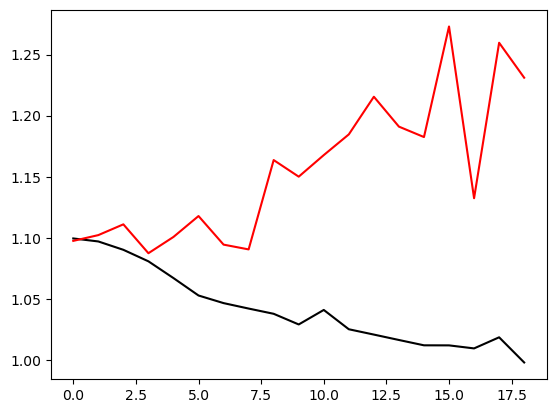

In [49]:
plt.plot(range(0, len(history.history['loss'])), history.history['loss'], c='k')
plt.plot(range(0, len(history.history['loss'])), history.history['val_loss'], c='r')
plt.show()
     

In [50]:
input_test_scaled = scaler_input.transform(input_test)
# label_test_scaled = scaler_label.transform(label_test)

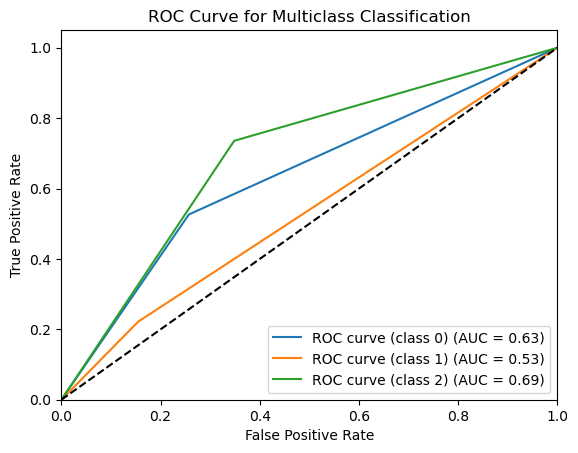

accuracy
0.49262820512820515
f1_score
0.46925534471432434
roc
0.6205754053467835


In [51]:

predictions_train = model.predict(
    x=input_train_scaled,
)

# Example predictions and true labels
predictions_roc = predictions_train.argmax(axis=1)
true_labels_roc = label_train.argmax(axis=1)
# Binarize the true labels
true_labels_bin = label_binarize(true_labels_roc, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): # Loop through each class
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions_roc == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

print('accuracy')
print(accuracy_score(label_train.argmax(axis=1),predictions_train.argmax(axis=1)))
print('f1_score')
print(f1_score(label_train.argmax(axis=1), predictions_train.argmax(axis=1), average='macro'))
print('roc')
print(np.mean([roc_auc[0],roc_auc[1],roc_auc[2]]))

In [52]:
# target_names = ['Q1','Q2','Q3','Q4','Q5']
target_names = ['L','N','H']

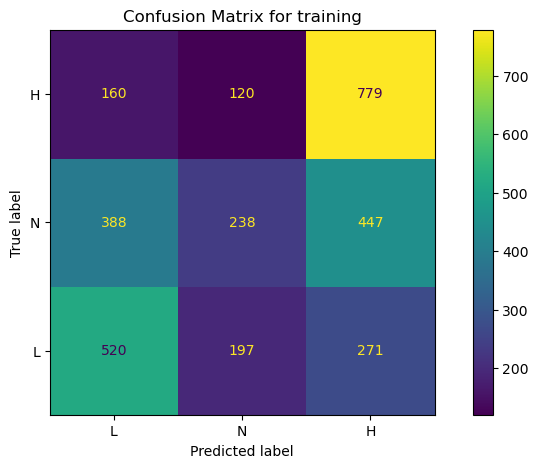

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(label_train.argmax(axis=1),predictions_train.argmax(axis=1), ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
plt.gca().invert_yaxis()
_ = ax.set_title(
    f"Confusion Matrix for training"
)


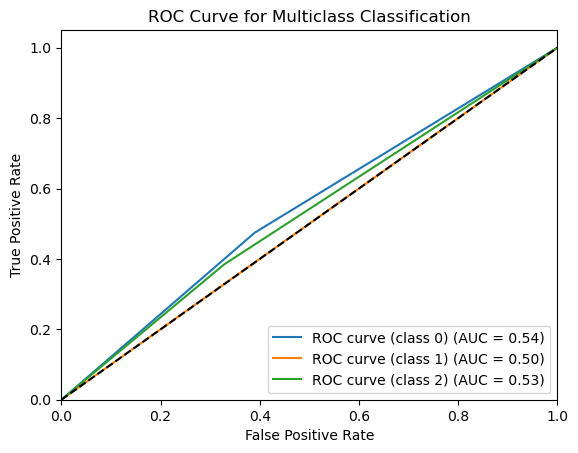

accuracy
0.37328094302554027
f1_score
0.3602062643410584
roc
0.523548796603612


In [54]:
# to predict, use predict call
predictions = model.predict(
    x=input_test_scaled,
)
   
# Example predictions and true labels
predictions_roc = predictions.argmax(axis=1)
true_labels_roc = label_test.argmax(axis=1)
# Binarize the true labels
true_labels_bin = label_binarize(true_labels_roc, classes=[0, 1, 2])


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): # Loop through each class
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions_roc == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

print('accuracy')
print(accuracy_score(label_test.argmax(axis=1), predictions.argmax(axis=1)))
print('f1_score')
print(f1_score(label_test.argmax(axis=1), predictions.argmax(axis=1), average='macro'))
print('roc')
print(np.mean([roc_auc[0],roc_auc[1],roc_auc[2]]))

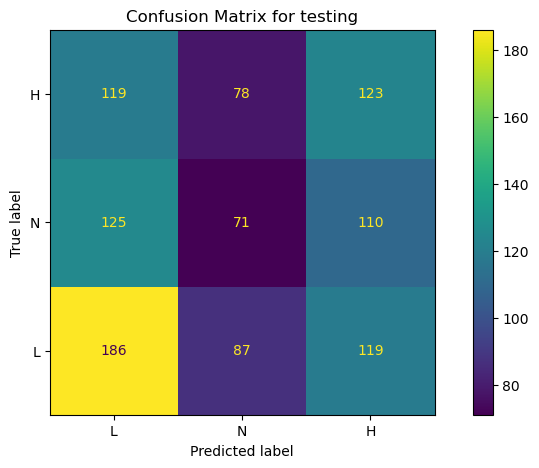

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(label_test.argmax(axis=1),predictions.argmax(axis=1), ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
plt.gca().invert_yaxis()
_ = ax.set_title(
    f"Confusion Matrix for testing"
)

In [56]:
## to do list

# - add more past precipitation
# - add day of the year
# - try those things first using just few inputs (then add complexity)
# - broad range of hyperparameters and complexity and optuna/keras-tuner
# - optimize accuracy 
# 

In [57]:
# try adding one variable
# without additional variable acc: 0.421 auc: 0.558
# first pc only: acc: 0.365 roc: 0.5275
# selected pcs: accuracy 0.375 auc:0.527
# 10 first pcs: accuracy 0.4194499017681729 roc: 0.549282842816269
# 20 pcs: accuracy 0.4430255402750491 roc 0.5662211241113173


In [58]:
# 0 -accuracy 0.37721021611001965 - f1_score 0.371777903178187 -roc 0.5380396416019653
# 1 -accuracy 0.3614931237721022 - f1_score 0.2849382187795613 - roc 0.53999228652976
# 2 - acc:0.39, auc:0.540
# 3 - acc:0.388, auc:0.5308
# 4 - acc:0.41, auc:0.54
# 5 - acc:0.33, auc:0.52

# optimization 

In [63]:
import optuna
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import time
import pickle

In [64]:

# study_name = 'study_may2'
# with open(f"{study_name}.pkl", "rb") as f:
#     study = pickle.load(f)

In [65]:
# df_study = study.trials_dataframe()

In [66]:
# df_study.sort_values('value',ascending=False).iloc[:20]

In [67]:
# best_params = study.trials[1825].params

# Final model

In [302]:
# best_params = {'depth1': 8, 'depth2': 3, 'depth3': 3, 'width1': 299, 'width2': 40, 'width3': 9, 'dropout': 0.0030671976340009427, 'regularization_factor': 6.241159934612165e-05, 'learning_rate': 0.0749466289777632, 'batch_size': 32, 'activation': 'tanh', 'optimizer': 'sgd'}
# best_params = {'depth1': 8, 'depth2': 3, 'depth3': 3, 'width1': 290, 'width2': 36, 'width3': 8, 'dropout': 0.002255409093299632, 'regularization_factor': 0.00017355708055331875, 'learning_rate': 0.06990953344395477, 'batch_size': 32, 'activation': 'tanh', 'optimizer': 'sgd'}
best_params = {'depth1': 7, 'depth2': 4, 'depth3': 2, 'width1': 234, 'width2': 36, 'width3': 13, 'dropout': 0.2547525692804984, 'regularization_factor': 0.0017142974641203667, 'learning_rate': 0.028533093069217946, 'batch_size': 32, 'activation': 'tanh', 'optimizer': 'sgd'}
# best_params = {'depth1': 7, 'depth2': 2, 'depth3': 4, 'width1': 151, 'width2': 26, 'width3': 16, 'dropout': 0.05504629358960575, 'regularization_factor': 0.004355992437533073, 'learning_rate': 0.018907476449867316, 'batch_size': 16, 'activation': 'tanh', 'optimizer': 'sgd'}
##best_params = {'depth1': 4, 'depth2': 4, 'depth3': 7, 'width1': 112, 'width2': 20, 'width3': 19, 'dropout': 0.2998494044344885, 'regularization_factor': 0.004805386389709655, 'learning_rate': 0.00045617160081789035, 'batch_size': 64, 'activation': 'tanh', 'optimizer': 'rmsprop'}
# best_params = {'depth1': 2, 'depth2': 8, 'depth3': 1, 'width1': 229, 'width2': 38, 'width3': 13, 'dropout': 0.1364884754145021, 'regularization_factor': 0.009004863109311458, 'learning_rate': 0.00011820594688900237, 'batch_size': 128, 'activation': 'tanh', 'optimizer': 'rmsprop'}
# best_params = {'depth1': 2, 'depth2': 6, 'depth3': 2, 'width1': 215, 'width2': 39, 'width3': 15, 'dropout': 0.09528473668513772, 'regularization_factor': 0.00928519095066077, 'learning_rate': 8.350440964555995e-05, 'batch_size': 16, 'activation': 'tanh', 'optimizer': 'rmsprop'}
# best_params = {'depth1': 2, 'depth2': 6, 'depth3': 2, 'width1': 211, 'width2': 39, 'width3': 15, 'dropout': 0.15489064104556702, 'regularization_factor': 0.009405164761754578, 'learning_rate': 8.2194952105878e-05, 'batch_size': 16, 'activation': 'tanh', 'optimizer': 'rmsprop'}
# best_params = {'depth1': 2, 'depth2': 6, 'depth3': 3, 'width1': 194, 'width2': 40, 'width3': 18, 'dropout': 0.07341679152646255, 'regularization_factor': 0.009565448361464331, 'learning_rate': 0.00013719448959430492, 'batch_size': 16, 'activation': 'tanh', 'optimizer': 'rmsprop'}




In [303]:
best_params

{'depth1': 7,
 'depth2': 4,
 'depth3': 2,
 'width1': 234,
 'width2': 36,
 'width3': 13,
 'dropout': 0.2547525692804984,
 'regularization_factor': 0.0017142974641203667,
 'learning_rate': 0.028533093069217946,
 'batch_size': 32,
 'activation': 'tanh',
 'optimizer': 'sgd'}

In [304]:
# del(model)
keras.backend.clear_session()

# Choose activation function
activation = {'relu': relu, 'sigmoid': sigmoid, 'tanh': tanh}[best_params['activation']]

# Choose optimizer

if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'sgd':
    optimizer = SGD(learning_rate=best_params['learning_rate'])
else:
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])

# Build the model
model = keras.Sequential()
model.add(keras.Input(shape=(input_train_scaled.shape[1],)))

for _ in range(best_params['depth1']):
    model.add(keras.layers.Dense(units=best_params['width1'], activation=best_params['activation'], kernel_regularizer=l2(best_params['regularization_factor'])))
model.add(keras.layers.Dropout(best_params['dropout']))

for _ in range(best_params['depth2']):
    model.add(keras.layers.Dense(units=best_params['width2'], activation=best_params['activation'], kernel_regularizer=l2(best_params['regularization_factor'])))
model.add(keras.layers.Dropout(best_params['dropout']))

for _ in range(best_params['depth3']):
    model.add(keras.layers.Dense(units=best_params['width3'], activation=best_params['activation'], kernel_regularizer=l2(best_params['regularization_factor'])))

model.add(keras.layers.Dense(units=3, activation='softmax'))

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    x=input_train_scaled,
    y=label_train,
    batch_size=best_params['batch_size'],
    epochs=100,
    verbose=0,
    validation_split=0.15,
    callbacks=[EarlyStopping(monitor='val_loss', patience=15)]
)

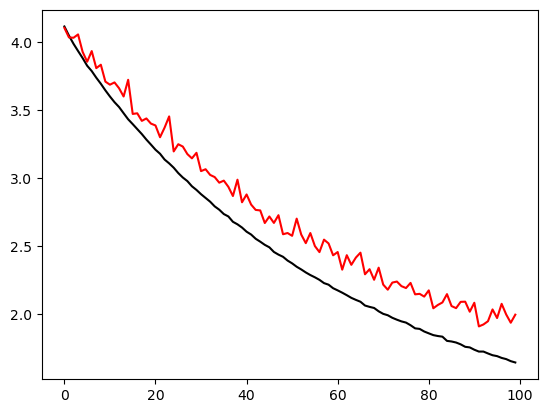

In [305]:
plt.plot(range(0, len(history.history['loss'])), history.history['loss'], c='k')
plt.plot(range(0, len(history.history['loss'])), history.history['val_loss'], c='r')
plt.show()
     

In [306]:
input_test_scaled = scaler_input.transform(input_test)
# label_test_scaled = scaler_label.transform(label_test)

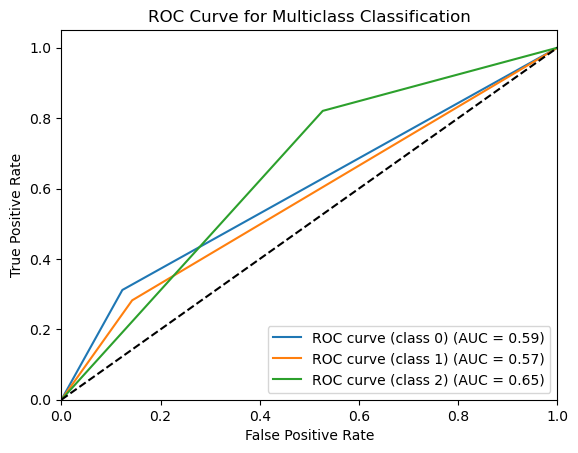

accuracy
0.47435897435897434
f1_score
0.4451101263044735
roc
0.6037077373876755


In [307]:

predictions_train = model.predict(
    x=input_train_scaled,
)

# Example predictions and true labels
predictions_roc = predictions_train.argmax(axis=1)
true_labels_roc = label_train.argmax(axis=1)
# Binarize the true labels
true_labels_bin = label_binarize(true_labels_roc, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): # Loop through each class
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions_roc == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

print('accuracy')
print(accuracy_score(label_train.argmax(axis=1),predictions_train.argmax(axis=1)))
print('f1_score')
print(f1_score(label_train.argmax(axis=1), predictions_train.argmax(axis=1), average='macro'))
print('roc')
print(np.mean([roc_auc[0],roc_auc[1],roc_auc[2]]))

In [308]:
# target_names = ['Q1','Q2','Q3','Q4','Q5']
target_names = ['L','N','H']

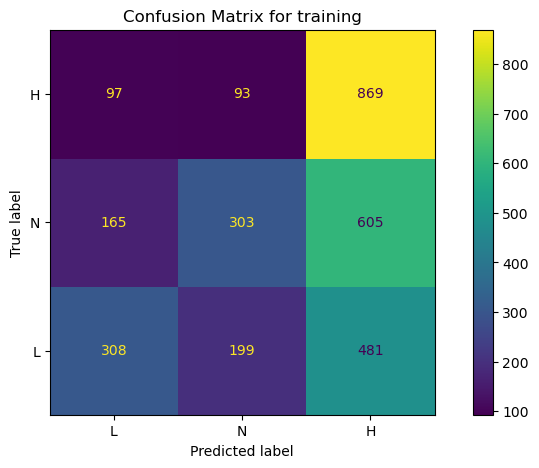

In [309]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(label_train.argmax(axis=1),predictions_train.argmax(axis=1), ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
plt.gca().invert_yaxis()
_ = ax.set_title(
    f"Confusion Matrix for training"
)


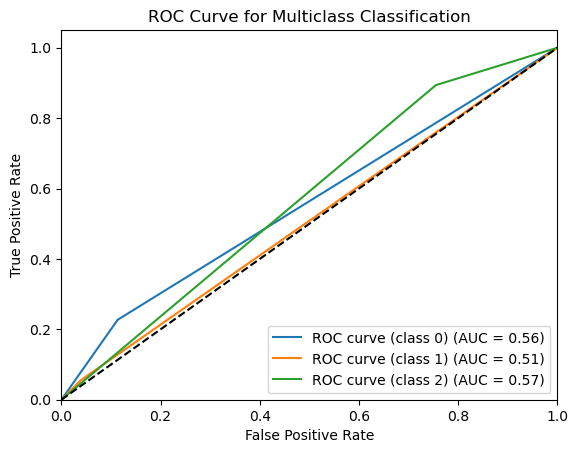

accuracy
0.3850687622789784
f1_score
0.3080614113046926
roc
0.5447646120310758


In [310]:
# to predict, use predict call
predictions = model.predict(
    x=input_test_scaled,
)
   
# Example predictions and true labels
predictions_roc = predictions.argmax(axis=1)
true_labels_roc = label_test.argmax(axis=1)
# Binarize the true labels
true_labels_bin = label_binarize(true_labels_roc, classes=[0, 1, 2])


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): # Loop through each class
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions_roc == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

print('accuracy')
print(accuracy_score(label_test.argmax(axis=1), predictions.argmax(axis=1)))
print('f1_score')
print(f1_score(label_test.argmax(axis=1), predictions.argmax(axis=1), average='macro'))
print('roc')
print(np.mean([roc_auc[0],roc_auc[1],roc_auc[2]]))

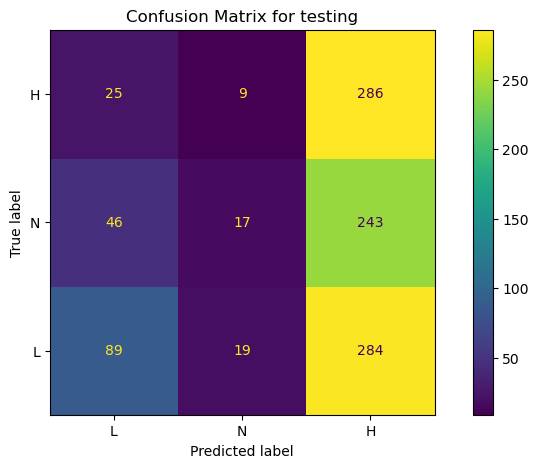

In [311]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(label_test.argmax(axis=1),predictions.argmax(axis=1), ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
plt.gca().invert_yaxis()
_ = ax.set_title(
    f"Confusion Matrix for testing"
)